In [1]:
import pandas as pd
from sdv.single_table import TVAESynthesizer

from domias.evaluator import evaluate_performance
from domias.models.generator import GeneratorInterface
from domias.models.ctgan import CTGAN


from scipy import stats
from scipy.stats import multivariate_normal


import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing, fetch_covtype, load_digits

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
#Import dataset
df_uci = pd.read_csv(r'C:\Users\jordy\OneDrive\MSc_Python\Individual_Project\Data\UCI_Credit_Card.csv')
df_uci.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
#convert dataframe to array
arr_uci = np.array(df_uci.iloc[:, 1:])
arr_uci.shape

(30000, 24)

In [4]:
def get_dataset() -> np.ndarray:
    def data_loader() -> np.ndarray:
        scaler = StandardScaler()
        X =arr_uci
        np.random.shuffle(X)
        return scaler.fit_transform(X)

    return data_loader()

p_G_evaluated
[4.44703320e-08 7.09137980e-08 3.83544389e-08 ... 1.01410844e-12
 8.21731152e-08 5.18955286e-30]
p_R_evaluated
[5.54727771e-05 1.19276964e-04 3.71893206e-05 ... 6.13674724e-11
 5.71338129e-06 6.68283852e-28]
test1
Synth_set
            0         1         2         3         4         5         6  \
0   -1.227167 -1.079150  0.868540  0.868724  0.914302 -0.737991 -0.715886   
1    0.806122 -1.071945 -1.059834  1.589322 -0.872763 -0.722232 -0.695593   
2    0.802787  0.197003 -1.041967  1.247933  0.908753 -1.575014 -1.550494   
3    0.807904  0.190350  0.860806 -0.749432  0.018648  0.111986  0.138932   
4   -1.224278 -1.082029 -1.053464  0.928555  0.024082  0.118032  0.136389   
..        ...       ...       ...       ...       ...       ...       ...   
495 -1.238978  0.189814 -1.052386 -0.022871  0.023520  0.107878  0.134744   
496 -1.238820  0.190610  0.867975  2.848119  0.018934  0.104890  0.124238   
497 -1.243490 -1.071780 -1.044789 -0.164467  3.012094  1.799268  2.29

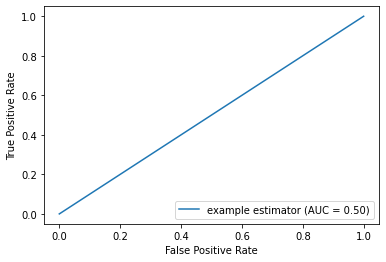

fpr: [0.  0.5 1. ]
tpr: [0.  0.5 1. ]


In [ ]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 3000 #held out set
training_epochs = [1000]
training_sizes = [3000]
#synthetic_sizes = [200]
density_estimator = "kde"  # prior, kde, bnaf
gen_size = 500 #same as synthetic_sizes

method = "CTGAN"

leave_one_out_results = {}

for i, col in enumerate(df_dataset.columns):
    df_temp = df_dataset.copy()
    df_temp.drop(columns=[col], inplace=True)
    arr_temp = np.array(df_temp)

    # Create a dictionary to store the results for the current column
    column_results = {}

    # Set the number of iterations
    num_iterations = 5

    for iteration in range(1, num_iterations+1):
        # Initialize the result dictionary for the current iteration
        iteration_results = {}

        for training_size in training_sizes:
            # Initialize the result dictionary for the current training size
            size_results = {}

            for training_epoch in training_epochs:
                generator = get_generator(
                    gan_method=method,
                    epochs=training_epoch,
                )

                perf = evaluate_performance(
                    generator,
                    arr_temp,
                    training_size,
                    reference_set_size,
                    training_epochs=training_epoch,
                    synthetic_sizes=[gen_size],
                    density_estimator=density_estimator,
                )

                # Store the MIA performance for the current training size and epoch
                size_results[training_epoch] = perf[gen_size]["MIA_performance"]

            # Store the results for the current training size
            iteration_results[training_size] = size_results

        # Store the results for the current iteration
        column_results[iteration] = iteration_results
    
    # Store the results for the current column
    leave_one_out_results[col] = column_results
    

# Print the results
for col, results in leave_one_out_results.items():
    print(f"Column Omitted {col}:")
    for iteration, iteration_results in results.items():
        print(f"Iteration {iteration}:")
        for training_size, size_results in iteration_results.items():
            print(f"Training Size {training_size}:")
            for training_epoch, mia_performance in size_results.items():
                print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
            print()

In [ ]:
# Create empty lists to store the results
iterations = []
epochs = []
srcs = []
aucrocs = []
column_ablated = []

# Iterate over the results
for col, results in leave_one_out_results.items():
    for iteration, iteration_results in results.items():
        for training_size, size_results in iteration_results.items():
            for training_epoch, mia_performance in size_results.items():
                # Append values to the lists
                iterations.append(iteration)
                epochs.append(training_epoch)
                srcs.append(list(mia_performance.keys())[8])
                aucrocs.append(list(mia_performance.values())[8]['aucroc'])
                column_ablated.append(col)  # Add the column_ablated value

# Create a list of dictionaries containing the data
data_list = [{'column_ablated': column, 'iteration': iteration, 'epoch': epoch, 'src': src, 'aucroc': aucroc}
             for column, iteration, epoch, src, aucroc in zip(column_ablated, iterations, epochs, srcs, aucrocs)]

# Create a DataFrame from the list of dictionaries
data = pd.DataFrame(data_list)

# Convert data types if needed
data['iteration'] = data['iteration'].astype(int)
data['epoch'] = data['epoch'].astype(int)
data['aucroc'] = data['aucroc'].astype(float)
data.to_csv('domias_kde_col_abl_UCI.csv')
data

In [ ]:
mean_values = data.groupby('column_ablated')['aucroc'].mean()

print(mean_values)

In [ ]:
sns.barplot(data=data, x='column_ablated', y='aucroc' )

# Customize the plot
plt.xlabel('Column ablated')
plt.ylabel('AUC-ROC')
plt.title('MIA Performance for Column Ablation Study')
plt.ylim(ymin=0.475, ymax=0.525)
#plt.legend(title='src')
#plt.grid(True)
plt.show()

In [ ]:
# for col, results in leave_one_out_results.items():
#     print(f"Column Omitted {col}:")
#     for iteration, iteration_results in results.items():
#         print(f"Iteration {iteration}:")
#         for training_size, size_results in iteration_results.items():
#             print(f"Training Size {training_size}:")
#             for training_epoch, mia_performance in size_results.items():
#                 print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
#             print()


# # Create empty lists to store the results
# epochs = []
# srcs = []
# aucrocs = []


# # Iterate over the results
# for col, results in leave_one_out_results.items():
#     for iteration, iteration_results in results.items():
#         for training_size, size_results in iteration_results.items():
#             for training_epoch, mia_performance in size_results.items():
#                 epochs.append(training_epoch)
#                 srcs.append(list(mia_performance.keys()))
#                 aucrocs.append([value['aucroc'] for value in mia_performance.values()])

# # Create a DataFrame from the lists
# data = pd.DataFrame({'epoch': epochs, 'src': srcs, 'aucroc': aucrocs})

# # Convert lists to individual rows
# data = data.explode('src').explode('aucroc')

# # Convert data types
# data['epoch'] = data['epoch'].astype(int)
# data['aucroc'] = data['aucroc'].astype(float)

# #print(data.head())

# #Filtering for just domias results
# filtered_df = data[data['src'] == 'domias']

# filtered_df.reset_index(inplace=True)


# print(filtered_df.head())
# print(filtered_df.shape)

In [ ]:
filtered_df[filtered_df['index'] == 0].count()

In [ ]:
sns.barplot(data=filtered_df, x='index', y='aucroc')

# Customize the plot
plt.xlabel('Column ablated')
plt.ylabel('AUC-ROC')
plt.title('MIA Performance for Column Ablation Study')
plt.ylim(ymin=0.4, ymax=0.6)
#plt.legend(title='src')
#plt.grid(True)
plt.show()